# Let's Train SmolLM 135M



### Configure the machine and install packages


In [67]:
import os

#os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=8'

from typing import Literal

import jax

platform : Literal["darwin", "colab", "cuda"] = "darwin"

try:
    import google.colab
    platform = "colab"
except ImportError:
    devices = jax.devices()
    if any(d.platform == "gpu" for d in devices):
        platform = "cuda"

print(f"Running on {platform}")

if platform == "colab":
    !git clone https://github.com/novastar53/jaxpt
    !cd jaxpt && git checkout main && git pull
    !pip install tiktoken datasets --quiet
    !pip uninstall -y tensorflow

Running on colab
fatal: destination path 'jaxpt' already exists and is not an empty directory.
Already on 'main'
Your branch is up to date with 'origin/main'.
Already up to date.


In [68]:
from pathlib import Path
import sys

if platform == "colab":
    jaxpt_dir = str(Path().absolute() / "jaxpt" / "src" )
else:
    jaxpt_dir = str(Path().absolute().parent / "src" )


sys.path.append(jaxpt_dir)
print(jaxpt_dir)

/content/jaxpt/src


In [69]:
import os
import warnings

import jax
import flax
import jax.numpy as jnp
import numpy as np

from jax.sharding import Mesh, PartitionSpec, NamedSharding

# Hardware setup
print("JAX version:", jax.__version__)
print("Flax version", flax.__version__)
devices = jax.devices()
num_devices = len(devices)
print("Available devices:", num_devices)

requested_device = "gpu"

jax.config.update("jax_platform_name", requested_device) # Make sure we're using the GPU

mesh = Mesh(devices, ("devices",))
spec = PartitionSpec("devices",)
sharding = NamedSharding(mesh, spec)

device = jax.default_backend()
if device != requested_device:
    warnings.warn(f"not using {requested_device}. Using {device}")
else:
    print(f"using {device}")


#####################################
##        jax.lax matmul presets   ##
#####################################
## 'ANY_F8_ANY_F8_F32',
## 'ANY_F8_ANY_F8_F32_FAST_ACCUM'
## 'ANY_F8_ANY_F8_ANY'
## 'ANY_F8_ANY_F8_ANY_FAST_ACCUM'
## 'F16_F16_F16'
## 'F16_F16_F32'
## 'BF16_BF16_BF16'
## 'BF16_BF16_F32'
## 'BF16_BF16_F32_X3'
## 'BF16_BF16_F32_X6'
## 'TF32_TF32_F32'
## 'TF32_TF32_F32_X3'
## 'F32_F32_F32'
## 'F64_F64_F64'
#####################################

jax.config.update("jax_default_matmul_precision", "BF16_BF16_F32") # Set the default precision for matrix multiplication

#jax.config.update("jax_enable_x64", True) # Make sure the highest precision is enabled in case we need
#os.environ["NVIDIA_TF32_OVERRIDE"] = "1"
#os.environ["JAX_ENABLE_X64"] = "False"

if device == "tpu":
    def list_tpu_memory():
        devices = jax.devices()
        for device in devices:
            if 'TPU' in str(device.device_kind):
                print(f"Device: {device}, Memory: {device.memory_stats()['bytes_limit']/(1024*1024)},  Used: {device.memory_stats()['bytes_in_use']/(1024*1024)}")

    list_tpu_memory()

# Test the device
A = jnp.array(np.random.normal(size=(4096, 4096)), dtype=jnp.float32) # Make sure matmul is fast
%timeit (A@A).block_until_ready()

JAX version: 0.5.2
Flax version 0.10.6
Available devices: 1
using gpu
794 µs ± 9.27 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Initialize SmolLLM model and perform a sanity check

In [70]:
from flax import nnx

from jaxpt.infer import generate_completions, generate
from jaxpt.models import SmolLM, SmolLM_Config
from jaxpt.models.smol_lm import from_hf_pretrained
from jaxpt.utils import count_params, create_sharded_model

from transformers import AutoTokenizer

key = jax.random.PRNGKey(1337)
rngs = nnx.Rngs(key)
config = SmolLM_Config(dtype=jnp.bfloat16, \
                    #vocab_size=49152,
                    block_size=128,
                    n_layer=4,
                    n_embed=128,
                    n_head=4,
                    n_kv_head=2,
                    n_mlp_hidden=384,
                    use_cache=False,
                    mesh=mesh,
                    sdpa_implementation="cudnn" if device=="gpu" else "xla")
nnx.display(config)
with mesh:
    m = create_sharded_model(SmolLM, config, rngs)
    #m = SmolLM(config, rngs)
    #graphdef, rngstate, state = nnx.split(m, nnx.RngState, ...)
    #nnx.display(state)
    #m = load_checkpoint("run_20250311_uqdwjq", 5600)
    #m = from_hf_pretrained(config, rngs)

    graphdef, rngstate, state = nnx.split(m, nnx.RngState, ...)
    total_params = count_params(m)

    print(f"Parameter Count: {total_params:,}")
    nnx.display(state)

    tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM-135M")
    #completions = generate_completions(m, enc=tokenizer, num_completions=5, max_length=21, prefix="Ducks quack, donkeys bray, cats mew, horses")
    #for completion in completions:
    #    print(completion)

Parameter Count: 7,220,480


In [71]:
jax.debug.visualize_array_sharding(state.wte.embedding.value)

         
         
         
         
         
  GPU 0  
         
         
         
         
         

### Configure Training Run

In [72]:
from datetime import datetime
import random
import string


def generate_random_code(length=6):
    return ''.join(random.choices(string.ascii_lowercase, k=length))

timestamp = datetime.now().strftime("%Y%m%d")
random_code = generate_random_code()

run_dirname = f"run_{timestamp}_{random_code}"
print(f"Run: {run_dirname}")

if platform == "colab":
  output_dir = Path().absolute().parent
elif platform == "cuda":
  output_dir = Path("/home/ubuntu/gpt2-train") # Lambda Labs setup
else:
  output_dir = Path().absolute().parent # Local setup

# Create checkpoint dir
checkpoint_dir = output_dir / "checkpoints"
checkpoint_dir.mkdir(parents=True, exist_ok=True)
print(f"Checkpoint directory: {checkpoint_dir}")

# Create log dir
log_dir = output_dir / "logs"
log_dir.mkdir(parents=True, exist_ok=True)
print(f"Log directory: {log_dir}")

def save_checkpoint(m, run_dirname, step):
  checkpoint_path = checkpoint_dir / run_dirname / f"checkpoint-{step}.pt"
  m.save_checkpoint(checkpoint_path)

def load_checkpoint(model, run_dirname, step):
  checkpoint_path = checkpoint_dir / run_dirname / f"checkpoint-{step}.pt"
  m = model.load_checkpoint(checkpoint_path, rngs)
  return m

Run: run_20250718_cmxakz
Checkpoint directory: /checkpoints
Log directory: /logs


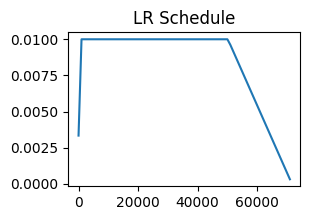

weight decay param count: 7,219,328
tokens/batch: 4,096
block size: 128
batch size: 32
no. gradient accumulation steps: 1
effective batch size: 32
effective batch size per device:  32
max steps: 71,667


In [73]:
import dataclasses

import optax


############################
# Nvidia A100 (x 8) Config #
############################

@dataclasses.dataclass
class TrainerConfig:
  num_tokens_per_batch: int = 2**12 # 2**19, 0.5 million as per the GPT 3.5 paper
  mB: int = 32 * num_devices
  T: int = 128
  max_steps: int = int((2000*146776) // (2**12))
  max_lr: float = 1e-2
  min_lr: float = max_lr * 0.1
  max_grad_norm: float = 1.0  # Clip gradients to this norm
  warmup_steps: int = 3
  print_interval: int = 5
  eval_interval: int = 5000
  checkpoint_interval: int = 10000
  grad_accumulation_steps: int = num_tokens_per_batch // (mB * T) # Number of steps over which to average the gradient


##############
# CPU Config #
##############

trconf = TrainerConfig()
'''
trconf = TrainerConfig(
  num_tokens_per_batch=2**9,
  mB=2**4,
  T=2**5,
  max_steps=9*48, # 6 epoch(s)
  max_lr=6e-4,
  min_lr=6e-5,
  max_grad_norm=1.0,
  warmup_steps=10,
  print_interval=1,
  eval_interval=50,
  checkpoint_interval=0,

)

trconf.grad_accumulation_steps =  trconf.num_tokens_per_batch // (trconf.mB * trconf.T * num_devices) # Number of steps over which to average the gradient
'''

# Set up the optimizer
cool_down_period = 0.3
def trapezoidal_schedule(step):

    warmup_lr = trconf.max_lr * (step + 1) / trconf.warmup_steps
    cooldown_lr = trconf.max_lr * (trconf.max_steps - step) / (trconf.max_steps - (1 - cool_down_period) * trconf.max_steps)

    return jnp.where(step < trconf.warmup_steps,
                     warmup_lr,
                     jnp.where(step < (1 - cool_down_period) * trconf.max_steps, trconf.max_lr, cooldown_lr))

steps = range(0, trconf.max_steps, 1000)
total_schedule = [ trapezoidal_schedule(step) for step in steps ]
import matplotlib.pyplot as plt
plt.figure(figsize=(3,2))
plt.plot(steps, total_schedule)
plt.title("LR Schedule")
plt.show()

# Generate a weight decay mask
# First split the model into params and variables
graphdef, params, variables = nnx.split(m, nnx.Param, nnx.Variable)
# Then create a mask for the weight decay params
weight_decay_mask = jax.tree_util.tree_map(lambda x: len(x.shape) > 1, params)

tx = optax.chain(
    #optax.clip_by_global_norm(trconf.max_grad_norm),
    #optax.adamw(trapezoidal_schedule, b1=0.9, b2=0.95, weight_decay=0.1, mask=weight_decay_mask),
    optax.adam(trapezoidal_schedule)
)
optimizer = nnx.Optimizer(m, tx)

# count the number of weight decay params
def f(x, y):
    if x:
        return y.size
    return 0

weight_decay_params = jax.tree_util.tree_map(f, weight_decay_mask, params)
weight_decay_param_count = jax.tree_util.tree_reduce(lambda x, y: x + y, weight_decay_params, 0)


print(f"weight decay param count: {weight_decay_param_count:,}")
print(f"tokens/batch: {trconf.num_tokens_per_batch:,}")
print(f"block size: {trconf.T}")
print(f"batch size: {trconf.mB}")
print(f"no. gradient accumulation steps: {trconf.grad_accumulation_steps}")
print(f"effective batch size: {trconf.grad_accumulation_steps * trconf.mB}")
print(f"effective batch size per device: ", trconf.grad_accumulation_steps * trconf.mB // num_devices)
print(f"max steps: {trconf.max_steps:,}")


### DataLoader and Validation Setup



In [74]:
from jaxpt.dataloaders import DataLoader, HuggingfaceDataLoader, CloudDataLoader

batch_size = trconf.T * trconf.mB * trconf.grad_accumulation_steps
batch_memory = batch_size*2
print(f"Batch Size (Tokens): {batch_size:,} | Batch Memory: {batch_memory/1024} MB")

'''
train_dl = HuggingfaceDataLoader(batch_size=trconf.mB * DATA_DIMS,
                                 block_size=trconf.T,
                                 device_rank=1,
                                 tokenizer="HuggingFaceTB/SmolLM-135M",
                                 dataset_paths=["HuggingFaceTB/smollm-corpus",
                                                "HuggingFaceTB/smollm-corpus",
                                                "HuggingFaceTB/smollm-corpus"],
                                 dataset_names=["cosmopedia-v2",
                                                "python-edu",
                                                "fineweb-edu-dedup"],
                                 probabilities=[0.111, 0.016 , 0.873],
                                 label="train",
                                 random_seed=1337,
                                 buffer_size=10_000,
                                 streaming=True)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "./alpha-448101-282bc1b884cd.json"

train_dl = CloudDataLoader(bucket_name="jaxpt_datasets",
                      bucket_prefix="fineweb-edu-100b/processed",
                      batch_size=trconf.mB,
                      block_size=trconf.T,
                      device_rank=1,
                      label="train")

'''
train_dl = DataLoader(dirpath="/content/jaxpt/datasets/panchatantra-ryder/processed",
                      batch_size=trconf.mB,
                      block_size=trconf.T,
                      device_rank=1,
                      label="train")



Batch Size (Tokens): 4,096 | Batch Memory: 8.0 MB
DataLoader initialized:
------------------------
label:          train
shards:         1
shard size:     146,776
batch size:     32
block size:     128
device rank:    1
------------------------


In [75]:
from jaxpt.utils import append_to_csv

train_losses = []
append_to_csv(log_dir / f"{run_dirname}_train.csv", ["step", "lr", "loss", "time", "tokens_processed", "tokens_per_sec"])
step = 0

Streaming output truncated to the last 5000 lines.
46695 | lr: 1.00e-02 | loss: 0.1702 | time: 13.88ms | tokens processed: 191,266,816 | tok/sec: 295,024.54
46700 | lr: 1.00e-02 | loss: 0.1857 | time: 13.11ms | tokens processed: 191,287,296 | tok/sec: 312,412.38
46705 | lr: 1.00e-02 | loss: 0.1695 | time: 13.35ms | tokens processed: 191,307,776 | tok/sec: 306,810.77
46710 | lr: 1.00e-02 | loss: 0.1753 | time: 14.11ms | tokens processed: 191,328,256 | tok/sec: 290,332.91
46715 | lr: 1.00e-02 | loss: 0.1740 | time: 14.02ms | tokens processed: 191,348,736 | tok/sec: 292,095.16
46720 | lr: 1.00e-02 | loss: 0.1837 | time: 13.86ms | tokens processed: 191,369,216 | tok/sec: 295,521.88
46725 | lr: 1.00e-02 | loss: 0.2093 | time: 14.31ms | tokens processed: 191,389,696 | tok/sec: 286,183.29
46730 | lr: 1.00e-02 | loss: 0.1806 | time: 14.73ms | tokens processed: 191,410,176 | tok/sec: 278,121.92
46735 | lr: 1.00e-02 | loss: 0.1749 | time: 14.60ms | tokens processed: 191,430,656 | tok/sec: 280,46

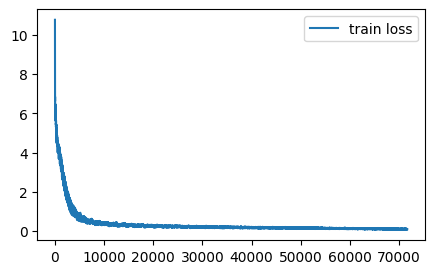

In [76]:
%matplotlib inline

import time

import matplotlib.pyplot as plt


def loss_fn(model, batch, targets):
    logits = model(batch)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits, targets)
    return loss.mean(), logits


@nnx.jit
def train_step(model, optimizer, batch, targets):
    (loss, logits), grads = nnx.value_and_grad(loss_fn, has_aux=True)(model, batch, targets)
    optimizer.update(grads)
    return loss, grads, logits


m.train()
try:
  while step < trconf.max_steps:
    start = time.time()
    batch, target = train_dl()
    batch = jax.device_put(batch.squeeze(), sharding)
    target = jax.device_put(target.squeeze(), sharding)
    loss, grads, logits = train_step(m, optimizer, batch, target)

    if step % trconf.print_interval == 0:
      # compute stats
      loss.block_until_ready()
      lr = trapezoidal_schedule(step)
      iter_time = time.time() - start
      sub_step_time = iter_time / trconf.grad_accumulation_steps
      tokens_per_sec = trconf.mB * trconf.T * trconf.grad_accumulation_steps / iter_time
      tokens_processed = (step+1) * trconf.grad_accumulation_steps * trconf.mB * trconf.T

      train_losses.append((step, loss))
      append_to_csv(log_dir / f"{run_dirname}_train.csv", [step, lr, loss, iter_time*1000, tokens_processed, tokens_per_sec])
      print(f"{step} | lr: {lr:0.2e} | "
            f"loss: {loss:0.4f} | "
            f"time: {iter_time*1000:0.2f}ms | "
            f"tokens processed: {tokens_processed:,} | "
            f"tok/sec: {tokens_per_sec:,.2f}")#, end="\r")
    if step % trconf.eval_interval == 0:
      print("Evaluation TBD")
      #save_checkpoint(m, run_dirname, step)
    step += 1

except KeyboardInterrupt:
    print("Received KeyboardInterrupt. Exiting...")

plt.figure(figsize=(5, 3))
plt.plot([x[0] for x in train_losses], [x[1] for x in train_losses], label="train loss")
plt.legend()
plt.savefig(log_dir / f"{run_dirname}.png", dpi=300, bbox_inches="tight", transparent=True)
plt.show()


In [77]:
completions = generate_completions(m, enc=tokenizer, max_length=40)
for completion in completions:
    print(completion)

Hello, I'm a language model,<jupyter_code>�

 percent<jupyter_start> d change dre remark<jupyter_code>�

 journal or I Quarterly<jupyter_text>�
 bre dimensional<jupyter_text> fertilizersAs thatode� under
Hello, I'm a language model,<jupyter_code>�

 percent<jupyter_start> d change dre remark<jupyter_code>�

 journal or I Quarterly<jupyter_text>�
 bre dimensional<jupyter_start>le s [-icre one
Hello, I'm a language model,<jupyter_code>�

 percent<jupyter_start> d change dre remark<jupyter_code>�

 percent s remark thatargs Include colonialOKomeseome�
imesleual<jupyter_code>
Hello, I'm a language model,<jupyter_code>�

 percent<jupyter_start> d change dre remark<jupyter_code>�

 percent s remark thatargs Include colonialOKomeseome�
imesleual<jupyter_code>
Hello, I'm a language model,<jupyter_code>�

 percent<jupyter_start> d change dre remark<jupyter_code>�

 journal or I Quarterly<jupyter_text>�
 bre dimensionalle s remark smow*�
Hello, I'm a language model,<jupyter_code>�

 percent<jupy